# Notes

Notes:

**Form of score**.  Given triple $(p_{ent}, p_{neu}, p_{con})$, do we do $p_{ent} - p_{con}$ or $log(p_{ent}/p_{con})$.  Note that using log amounts to the log-likelihood ratio of E vs C.  Assume each posterior is calibrated as:

$$
p_y(x) = Pr(Y=y|x) = \frac{Pr(x|Y=y)\pi_y}{\sum_{y'} Pr(x|Y=y')\pi_{y'}}
$$

so we form

$$
\frac{p_{ent}(x)}{p_{con}(x)} = \frac{Pr(x|Y=E)\pi_E}{Pr(x|Y=C)\pi_C}
$$

(because denominators from Bayes cancel).  If the training used balanced E/C priors then the priors also cancel, and taking logs we have

$$
\log \frac{p_E(x)}{p_C(x)} = \log \frac{Pr(x|Y=E)}{Pr(x|Y=C)} = \Lambda(x)
$$

Likelihoods multiply, so across multiple observations (sentences/clauses), the LLRs add:

$$
\Lambda(x_{1:m}) = \sum_{k=1}^m \Lambda(x_k)
$$

Note this is connected to a Bayes factor.  Given hypothesis $H$ and observation $x$, the Bayes factor is

$$
B(x) = \frac{Pr(x|H)}{Pr(x|\not H)}
$$

...


**Logit vs softmax probs.**  Note the embedder just returns logits $(a_E, a_N, a_C)$, and transforms them to (pseudo)probabilities via softmax:

$$
p_y = \frac{e^{a_y}}{Z}, \quad Z = \sum_{y'} e^{a_y'}
$$

Note the posterior odds of $E$ vs. $C$ (saying posterior because $p_E = P(Y=E|x)),

$$
\frac{p_E}{p_C} = \frac{e^{a_E}/Z}{e^{a_C}/Z} = e^{a_E - a_C}
$$

so the log-odds are $\log (p_E/p_C) = a_E - a_C$ (leaving out any bias term from imbalanced priors).

Now also note that the conditional probability of entailment, conditioned on just the entailment + contradiction subspace, is

$$
q = Pr(E|E\lor C, x) = \frac{p_E}{p_E+p_C} = \frac{e^{a_E}}{e^{a_E} + e^{a_C}} = \sigma (a_E - a_C)
$$

and so $\text{logit}(q) = a_E - a_C$.  (Logit as inverse of sigmoid)


**Calibrating to interview.**  We have for each clause/sentence $k$ the (potentially scaled) logit 

$$
\tilde{\ell}_k = \alpha (a_E - a_C)_k + \beta
$$

which together with the persona prior gives the sum $\tilde{L} = \ell_0 + \sum \tilde{\ell}_k$.  We want to regress this onto the interview score (from LLM-as-judge), but first need a way to map them monotonically to the same scale.

Platt, isotonic .... [ to do ]


**Sensitivity of embedder.**  Similar phrases give different entailment scores ("I am willing" vs "I would be willing").  Idea: have a paraphrase set $\{H_i\}$ for each hypothesis, score each sentence/clause against entire set and average.  Possibly:

$$
\ell(c) = \log \left( \frac{1}{m} \sum_i \exp (\ell_i(c)) \right)
$$

# rewards

In [1]:
import json
import sys
import os

# hack so we can import normally from other packages
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import torch

from agent.agent import Agent
from agent.llm_client import LLMClient
from mcts.mcts_node import ConversationState

/home/stmorse/projects/scope2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
NLI_MODEL = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"

class NLIWrapper:
    def __init__(self):
        model_name = NLI_MODEL
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # Move model to GPU
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_embed_and_prob(self, premise, hypothesis):
        inputs = self.tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")

        # debug for token-level inspection
        # tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Move inputs to same device as model
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # get embedding and logits
        with torch.no_grad():
            enc = self.model.deberta(**inputs)                    # base encoder
            pooled = self.model.pooler(enc.last_hidden_state)     # [1, hidden_size]
            features = self.model.dropout(pooled)                 # pre-classifier embedding
            logits = self.model.classifier(features)              # NLI logits (E/C/N)

        # features is the pair-specific embedding used for the decision
        embedding = features.squeeze(0).cpu()  # shape [hidden_size], here 1024
        probs  = logits.softmax(dim=-1).squeeze(0).cpu()

        return embedding, probs, logits.cpu()


# check single vs aggregate

- NLI encoder gives us logits $(a_e, a_n, a_c)$. 

- If we're interested in E vs C, we could consider the log odds $\log P(E) / P(C)$,

$$
\log \frac{P(E)}{P(C)} = \log \frac{e^{a_e}/Z}{e^{a_c}/Z} = a_e - a_c
$$

- If we're interested in E vs (N, C), we have $\log P(E) / (P(N) + P(C))$, 

$$
\log \frac{P(E)}{P(N)+P(C)} = \log \frac{e^{a_e}/Z}{(e^{a_n}+e^{a_c})/Z} = a_e - \log(e^{a_n} + e^{a_c})
$$

- Define $\ell_t$ as the log-odds for the state at time $t$.  We can either compute as a sum of all utterances scored individually, or send the entire state through the encoder.

- These are logits, if we do per-utterance (or even per-phrase), they are additive (under the possibly unjustified assumption of independence):

$$
\log \prod \Lambda_t = \sum \ell_t
$$

- Can include a prior (corresponding to the persona valence):

$$
\ell_T = \ell_0 + \sum \ell_t
$$

In [4]:
scenario_name = "fender"
LEVER = 0                   # which lever to use
v0 = 0.5                    # valence for agent 0
v1 = 1.0                    # valence for agent 1
temp = 0.8                  # temperature for agent LLMs

# load scenario
with open(f"../scenarios/{scenario_name}.json", "r") as f:
    scenario = json.load(f)
hypothesis = scenario["base"]
levers = scenario["levers"]

# initialize agents
valences = [v0, v1]
agents = {i: Agent(
    name=scenario["personas"]["names"][i],
    order=i,
    provider="ollama", 
    model="llama3.2:latest", 
    persona=Agent.build_persona(scenario, valences[i], i),
    forcing=False
) for i in range(2)}

# initialize embedders
nli_model = NLIWrapper()

Using device: cuda


In [ ]:
hypotheses = []

h_client = LLMClient(
    provider="ollama",
    model="llama3.2:latest",
    forcing=False
)

prompt = (
    "Consider the following statement: "
    "\n{hypo}\n"
    "Generate 5 semantically similar statements. "
    "Separate your statements with an asterisk (*). "
    "Provide only the 5 statements, nothing else."
)
# prompt = (
#     "You are designing a prompt for an LLM agent to rate its "
#     "agreement with some statement, on a scale of 1 to 10. "
#     "Provide a description of each rating on this scale to "
#     "help the agent choose an integer. "
#     "Be very concise, using only one short phrase per rating, "
#     "and format your response like this: rating=description"
# )

h = h_client.get_response(prompt.format(hypo=hypothesis))

hypotheses = [s.replace('*', '').strip() for s in h.split('*') if s.replace('*', '').strip()]

print("\n".join(hypotheses)) 

I'm a fan of American-made guitars and would consider purchasing from Fender.
I prefer Fender's electric instruments and may buy from them in the future.
I'm loyal to the Fender brand and might purchase their products online.
I have a strong affinity for Fender products and could buy from them again.
I'm interested in acquiring Fender-branded musical instruments and possibly making a purchase.


In [11]:
N_CONVOS = 50
conversations = []

for m in range(N_CONVOS):
    print(f"{m} ", end="")
    if m % 10 == 0: print()

    convo = []

    # initialize state
    state = ConversationState(
        messages=[scenario["prompt"]],
        agents=scenario["personas"]["names"],
    )

    convo.append(state)

    # run full conversation
    for turn in range(3):
        for a in [1,0]:
            response = agents[a].get_response(
                state, 
                lever=levers[LEVER] if a==1 else None,
                temperature=temp,
            )
            state = state.add_message(response)
            convo.append(state)

    conversations.append(convo)

0 
1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 
31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 

In [38]:
v0_ = (v0 + 1) / 2          # valence rescaled to [0, 1]
l0 = np.log(v0_ / (1-v0_))  # logit of scaled valence

e_scores = []               # logits (aggregated dialogue)
f_scores = []               # logits (full dialogue)
r_scores = []               # scaled interview scores

g_scores = []               # logits (aggregated, multiple hypotheses)
h_scores = []               # logits (full, multiple hypotheses)
q_scores = []               # scaled interview, multiple hypotheses

rscale = lambda r: (r - 1)/9  # rescale 1-10 -> [0, 1]

for i, convo in enumerate(conversations):
    if i % 10 == 0: print(i)

    # scores for this convo
    e, f, r = [], [], []
    g, h, q = [], [], []

    for state in convo[::2]:   # just score Agent 0
        # score aggregated utterances
        phrase_scores = []
        for phrase in state.messages[-1].split("."):
            s = nli_model.get_embed_and_prob(
                premise=phrase, hypothesis=hypothesis
            )
            phrase_scores.append(s[2].numpy())
        phrase_scores = np.vstack(phrase_scores).sum(axis=0)
        e.append(phrase_scores)

        # score entire dialogue
        all0 = "\n".join(state.get_messages_from_agent(agent=0))
        s = nli_model.get_embed_and_prob(
            premise=all0, hypothesis=hypothesis
        )
        f.append(s[2].numpy())

        # do interview
        rating = agents[a].interview(
            state, hypothesis=hypothesis, use_persona=True
        )
        r.append(rscale(rating))

        #

        # score aggregated against multiple hypotheses
        hypo_scores = []
        for hypo in hypotheses:
            phrase_scores = []
            for phrase in state.messages[-1].split("."):
                s = nli_model.get_embed_and_prob(
                    premise=phrase, hypothesis=hypo
                )
                phrase_scores.append(s[2].numpy())
            phrase_scores = np.vstack(phrase_scores).sum(axis=0)
            hypo_scores.append(phrase_scores)
        hypo_scores = np.vstack(hypo_scores).mean(axis=0)
        g.append(hypo_scores)

        # score full against multiple
        hypo_scores = []
        for hypo in hypotheses:
            all0 = "\n".join(state.get_messages_from_agent(agent=0))
            s = nli_model.get_embed_and_prob(
                premise=all0, hypothesis=hypo
            )
            hypo_scores.append(s[2].numpy())
        hypo_scores = np.vstack(hypo_scores).mean(axis=0)
        h.append(hypo_scores)

        # score interview against multiple
        hypo_scores = []
        for hypo in hypotheses:
            rating = agents[a].interview(
                state, hypothesis=hypo, use_persona=True
            )
            hypo_scores.append(rscale(rating))
        hypo_scores = np.array(hypo_scores).mean()
        q.append(hypo_scores)

    e_scores.append(np.vstack(e))
    f_scores.append(np.vstack(f))
    r_scores.append(np.vstack(r))

    g_scores.append(np.vstack(g))
    h_scores.append(np.vstack(h))
    q_scores.append(np.vstack(q))

0
10
20
30
40


In [25]:
l0

np.float64(1.0986122886681098)

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def logit(p, eps=0.001):
    return np.log((p + eps) / (1-p + eps))
def get_ell(scores, use_lse=False):
    if use_lse:
        lse = np.log(np.exp(scores[:,1]) + np.exp(scores[:,2]))
        return scores[:,0] - lse
    else:
        return scores[:,0] - scores[:,2]

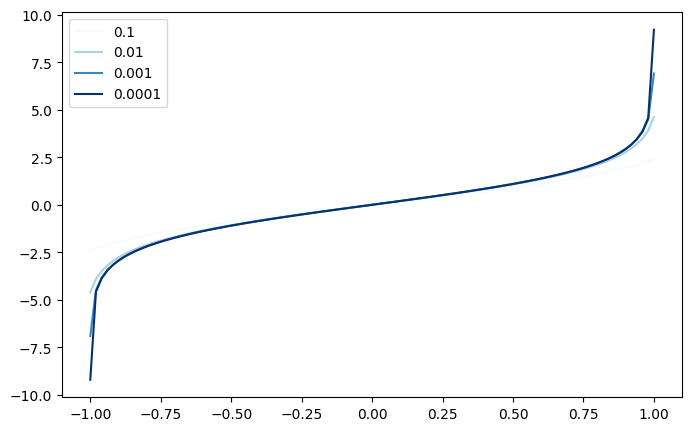

In [8]:
vs = np.linspace(-1,1,100)
vs_ = (vs + 1) / 2

fig, ax = plt.subplots(1,1, figsize=(8,5))

colors = plt.cm.Blues(np.linspace(0,1,4))

for i,eps in enumerate([0.1, 0.01, 0.001, 0.0001]):
    ls = logit(vs_, eps=eps)
    ax.plot(vs, ls, color=colors[i], linestyle='-', label=eps)

ax.legend()
plt.show()

In [14]:
lab = np.array([0])
ix = np.where(lab == 0)
print(ix)
print(ix[0])
print(ix[0][0])

(array([0]),)
[0]
0


In [24]:
logit(rscale(1))

np.float64(-6.90875477931522)

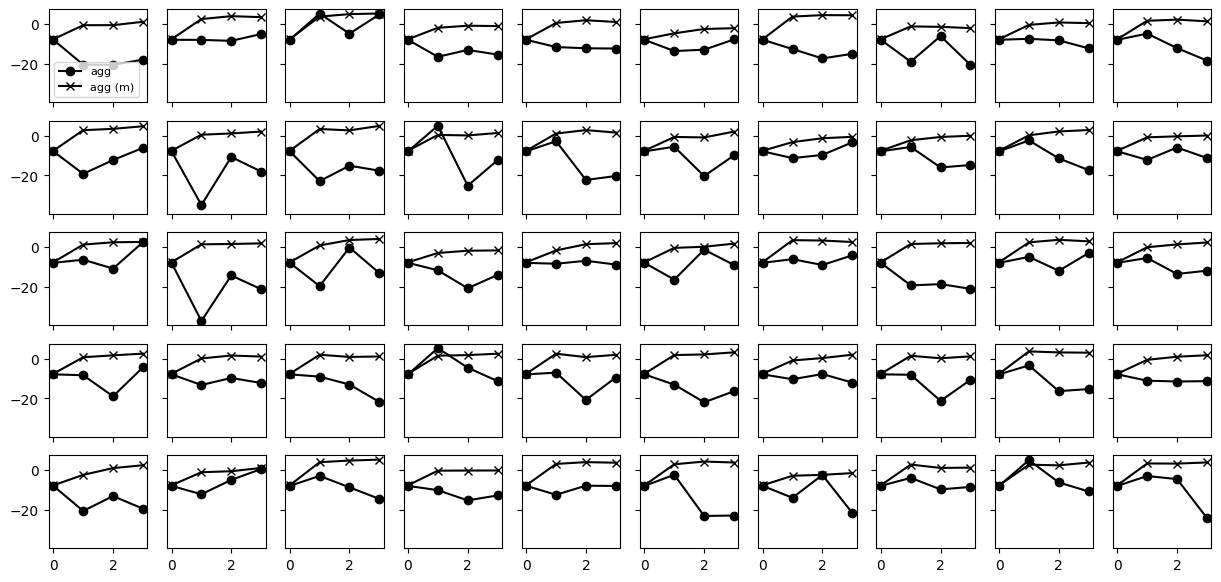

In [51]:
fig, axs = plt.subplots(5,10, figsize=(15,7), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    ax.plot(range(4), l0 + get_ell(e_scores[i], use_lse=True), 'ko-', label="agg")
    ax.plot(range(4), l0 + get_ell(h_scores[i], use_lse=True), 'kx-', label="agg (m)")
    
    # ax.plot(range(4), l0 + get_ell(f_scores[i]), 'go-', label="full")
    # ax.plot(range(4), l0 + get_ell(h_scores[i]), 'gx-', label="full (m)")
    
    # ax.plot(range(4), logit(r_scores[i][:]), 'co-', label="llm")
    # ax.plot(range(4), logit(q_scores[i][:]), 'cx-', label="llm (m)")

axs[0,0].legend(fontsize=8)

plt.show()

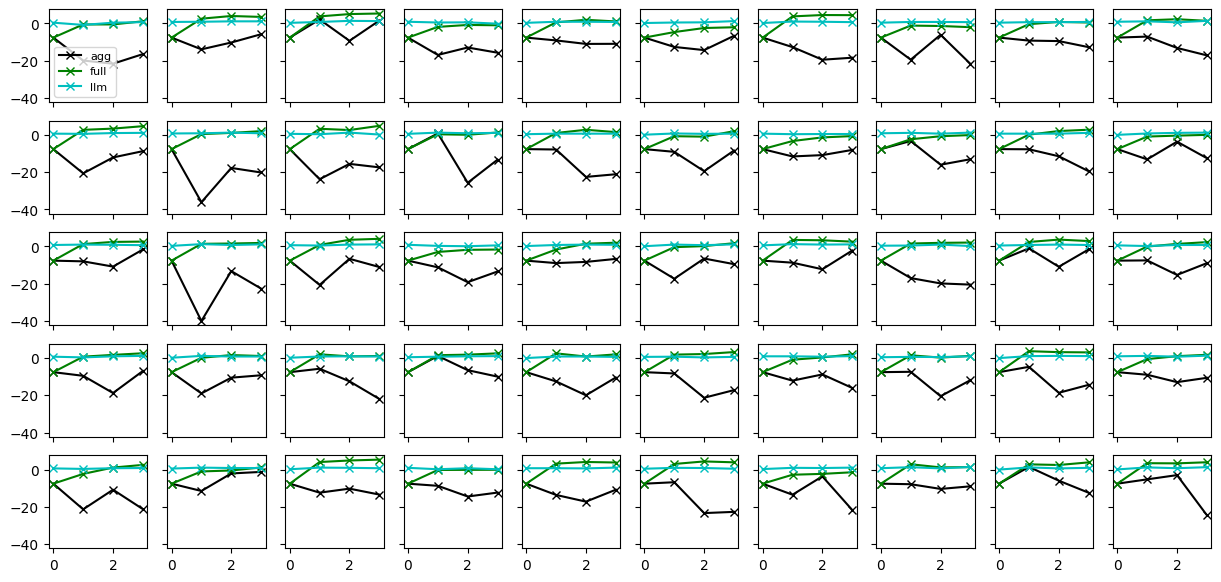

In [54]:
fig, axs = plt.subplots(5,10, figsize=(15,7), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    ax.plot(range(4), l0 + get_ell(g_scores[i], use_lse=True), 'kx-', label="agg")
    ax.plot(range(4), l0 + get_ell(h_scores[i], use_lse=True), 'gx-', label="full")
    ax.plot(range(4), logit(q_scores[i][:]), 'cx-', label="llm")

axs[0,0].legend(fontsize=8)

plt.show()

In [90]:
logit(rscale(2))

np.float64(-2.0716061679700735)

In [82]:
ez = np.stack(e_scores, axis=0)
fz = np.stack(f_scores, axis=0)
gz = np.stack(g_scores, axis=0)
hz = np.stack(h_scores, axis=0)

rz = np.stack([r.flatten() for r in r_scores], axis=0)
qz = np.stack([q.flatten() for q in q_scores], axis=0)

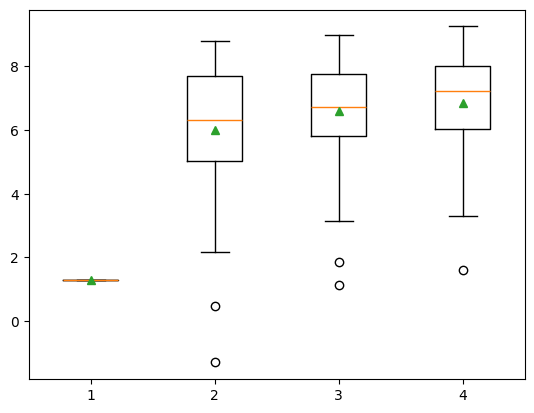

In [88]:
plt.boxplot(
    [l0 + get_ell(hz[:,i,:]) for i in range(4)],
    showmeans=True
)

# plt.boxplot(
#     [logit(rz[:,i]) for i in range(4)],
#     showmeans=True
# )

plt.show()

# older

In [11]:
scenario_name = "fender"
LEVER = 0                   # which lever to use
v0 = -0.25                  # valence for agent 0
v1 = 1.0                    # valence for agent 1
temp = 0.8                  # temperature for agent LLMs


# load scenario
with open(f"../scenarios/{scenario_name}.json", "r") as f:
    scenario = json.load(f)
hypothesis = scenario["base"]
levers = scenario["levers"]

# initialize agents
valences = [v0, v1]
agents = {i: Agent(
    name=scenario["personas"]["names"][i],
    order=i,
    provider="ollama", 
    model="llama3.2:latest", 
    persona=Agent.build_persona(scenario, valences[i], i),
    forcing=False
) for i in range(2)}

# initialize embedders
nli_model = NLIWrapper()

Using device: cuda


In [12]:
v0_ = (v0 + 1) / 2          # valence rescaled to [0, 1]
l0 = np.log(v0_ / (1-v0_))  # logit of scaled valence
e_scores = []               # logits (non-persona)
r_scores = []               # scaled interview scores

rscale = lambda r: (r - 1)/9  # rescale 1-10 -> [0, 1]

# initialize state
state = ConversationState(
    messages=[scenario["prompt"]],
    agents=scenario["personas"]["names"],
)

print(f"\033[93m{agents[0].name}:\033[0m {scenario['prompt']}")

# score
entail = nli_model.get_embed_and_prob(premise=scenario["prompt"], hypothesis=hypothesis)
rating = agents[0].interview(state, hypothesis=hypothesis, use_persona=True)

# append
e_scores.append(entail[2].numpy())
r_scores.append(rscale(rating))

# run full conversation
for turn in range(3):

    for a in [1,0]:
    
        response = agents[a].get_response(
            state, 
            lever=levers[LEVER] if a==1 else None,
            temperature=temp,
        )

        state = state.add_message(response)

        print(f"\033[93m{agents[a].name}:\033[0m {response}")

        if a == 0:
            # score
            entail = nli_model.get_embed_and_prob(
                premise="\n".join(state.get_messages_from_agent(agent=a)), 
                hypothesis=hypothesis
            )
            rating = agents[a].interview(
                state, hypothesis=hypothesis, use_persona=True
            )

            # append
            e_scores.append(entail[2].numpy())
            r_scores.append(rscale(rating))

e_scores = np.vstack(e_scores)
r_scores = np.array(r_scores)

print(e_scores.shape, r_scores.shape)

Jim: I'm in the market for a new guitar, any suggestions?
Rob: I've got just the thing - have you considered a Fender Stratocaster or Telecaster? These iconic models offer unbeatable tone and playability, with a reputation for withstanding even the most intense playing sessions. Trust me, once you plug in one of these babies, you'll be hooked!
Jim: I've heard great things about Fender guitars, but I'm not sure if they're for me - I've had some issues with the locking tremolos on my previous Stratocaster, which can be finicky to set up and adjust. That being said, I do love the look of a Telecaster, and their twangy tone is right up my alley, so maybe one of those would be worth checking out?
Rob: I completely understand your concerns about locking tremolos, but I'd argue that a well-set-up Stratocaster can be virtually hassle-free - it's all about finding the right adjustment sweet spot. That being said, Telecasters do have a reputation for being more straightforward in terms of setup 

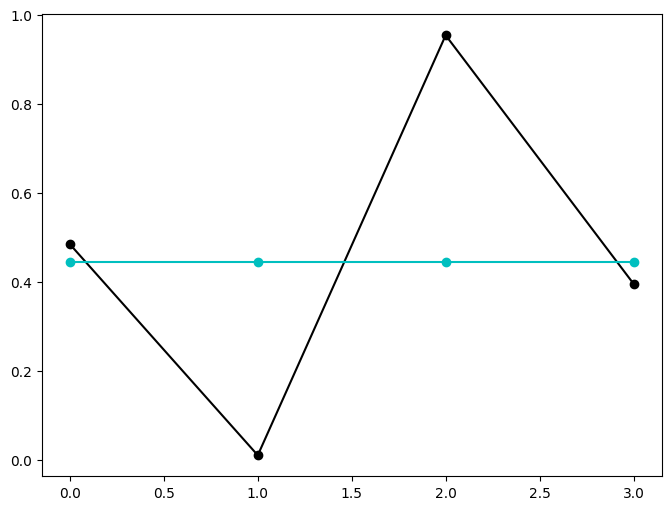

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ax.plot(range(4), sigmoid(e_scores[:,0] - e_scores[:,2]), 'ko-')
ax.plot(range(4), r_scores[:], 'co-')

plt.show()

In [9]:
emb, prob, logits = nli_model.get_embed_and_prob(
    "i sure love fender stratocasters", "i like fender products")

In [10]:
logits, prob

(tensor([[ 3.3394,  0.3051, -4.0047]]),
 tensor([9.5351e-01, 4.5875e-02, 6.1637e-04]))

In [10]:
eps = 0.01

for stance, phrase in scenario["personas"]["stance"].items():
    clauses = phrase.split(",")
    _, prob0 = nli_model.get_embed_and_prob(
        premise=clauses[0],
        hypothesis=hypothesis
    )
    _, probf = nli_model.get_embed_and_prob(
        premise=phrase,
        hypothesis=hypothesis
    )

    prob0 = prob0.numpy()
    probf = probf.numpy()

    print(
        f"{stance}: "
        f"  {[f"{p:.3f}" for p in prob0]} {np.log((prob0[0] + eps) / (prob0[2] + eps)):.3f}"
        f"  {[f"{p:.3f}" for p in probf]} {np.log((probf[0] + eps) / (probf[2] + eps)):.3f}")

-1.00:   ['0.000', '0.001', '0.999'] -4.605  ['0.000', '0.002', '0.998'] -4.604
-0.75:   ['0.000', '0.000', '0.999'] -4.608  ['0.000', '0.001', '0.999'] -4.607
-0.50:   ['0.000', '0.002', '0.998'] -4.591  ['0.000', '0.002', '0.998'] -4.593
-0.25:   ['0.002', '0.932', '0.066'] -1.832  ['0.003', '0.956', '0.041'] -1.380
0.00:   ['0.001', '0.256', '0.743'] -4.217  ['0.003', '0.983', '0.014'] -0.629
0.10:   ['0.003', '0.506', '0.491'] -3.675  ['0.003', '0.994', '0.002'] 0.073
0.20:   ['0.003', '0.997', '0.000'] 0.184  ['0.001', '0.999', '0.000'] 0.087
0.25:   ['0.001', '0.998', '0.001'] 0.053  ['0.002', '0.995', '0.003'] -0.060
0.30:   ['0.001', '0.999', '0.000'] 0.062  ['0.001', '0.998', '0.000'] 0.094
0.40:   ['0.024', '0.975', '0.000'] 1.218  ['0.006', '0.994', '0.000'] 0.426
0.50:   ['0.022', '0.978', '0.000'] 1.133  ['0.004', '0.996', '0.000'] 0.310
0.60:   ['0.022', '0.978', '0.000'] 1.133  ['0.004', '0.996', '0.000'] 0.307
0.70:   ['0.052', '0.948', '0.000'] 1.797  ['0.004', '0.996'

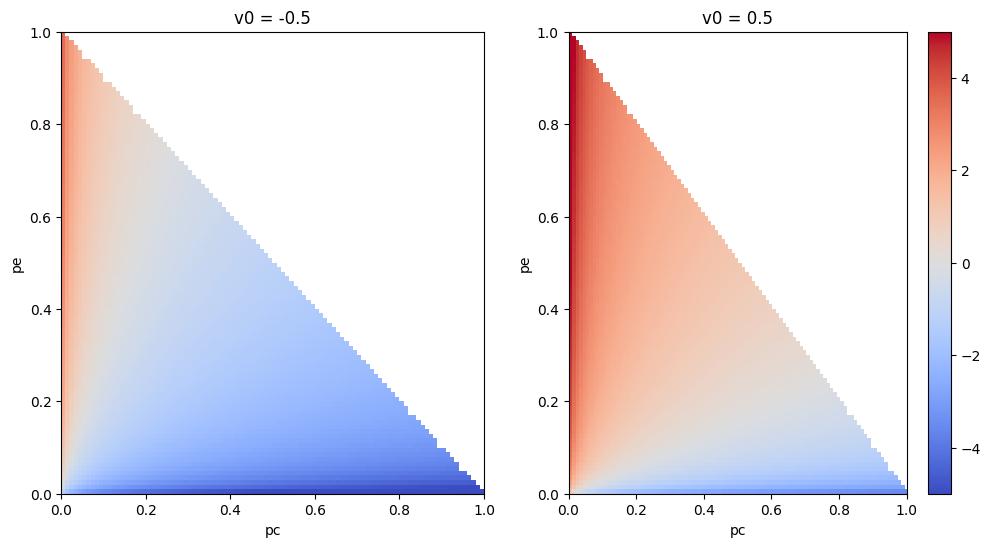

In [29]:
def llr(pe, pc, eps=0.01):
    return np.log((pe+eps)/(pc+eps))


fig, axs = plt.subplots(1,2, figsize=(12,6))

for k, v0 in enumerate([-0.5, 0.5]):
    pe_vals = np.linspace(0, 1, 100)
    pc_vals = np.linspace(0, 1, 100)
    llr_grid = np.zeros((len(pe_vals), len(pc_vals)))
    
    p0 = (v0+1)/2
    l0 = np.log(p0 / (1-p0))

    for i, pe in enumerate(pe_vals):
        for j, pc in enumerate(pc_vals):
            if pe + pc > 1:
                llr_grid[i,j] = np.nan
            else:
                llr_grid[i, j] = l0 + llr(pe, pc, eps)

    ax = axs[k]
    im = ax.imshow(
        llr_grid, extent=[0, 1, 0, 1], origin='lower', 
        aspect='auto', cmap='coolwarm', 
        vmin=-5, vmax=5
    )
    ax.set_title(f"v0 = {v0}")
    ax.set_xlabel("pc")
    ax.set_ylabel("pe")

plt.colorbar(im)
plt.show()

In [28]:
v0 = -0.5
p0 = (v0+1)/2
l0 = np.log(p0 / (1-p0))

print(l0)
print(llr(0.1, 0.9))
print(l0 + llr(0.1, 0.9))

-1.0986122886681098
-2.1129642337184795
-3.211576522386589


In [45]:
state = ConversationState(
    messages=[scenario["prompt"]],
    agents=scenario["personas"]["names"],
)

print(f"\033[93m{agents[0].name}:\033[0m {scenario['prompt']}")

ers = []
ers2 = []
ers3 = []
ers4 = []
rwps = []
rnps = []

ent_reward = nli_model.get_embed_and_prob(
    premise=scenario["prompt"], hypothesis=hypothesis) 
    
ent_reward2 = ent_reward

t = f"{agents[0].persona}\n {scenario['prompt']}"
ent_reward3 = nli_model.get_embed_and_prob(
    premise=t, hypothesis=hypothesis
)

ent_reward4 = ent_reward3

rating_with_persona = agents[0].interview(
    state, hypothesis=hypothesis, use_persona=True)

rating_no_persona = agents[0].interview(
    state, hypothesis=hypothesis, use_persona=False)

ers.append(ent_reward[1])
ers2.append(ent_reward2[1])
ers3.append(ent_reward3[1])
ers4.append(ent_reward4[1])
rwps.append(rating_with_persona)
rnps.append(rating_no_persona)

# run full conversation
for turn in range(3):

    for a in [1,0]:
    
        response = agents[a].get_response(
            state, 
            lever=levers[LEVER] if a==1 else None,
            temperature=0.7,
        )

        state = state.add_message(response)

        ent_reward = nli_model.get_embed_and_prob(
            premise=response, hypothesis=hypothesis) 
        
        ent_reward2 = nli_model.get_embed_and_prob(
            premise="\n".join(state.get_messages_from_agent(agent=a)), 
            hypothesis=hypothesis)
        
        # t = f"{agents[a].persona}\n {response}"
        t = f"{scenario["personas"]["stance"][f"{valences[a]:.2f}"]} {response}"
        ent_reward3 = nli_model.get_embed_and_prob(
            premise=t, hypothesis=hypothesis
        )

        # t = f"{agents[a].persona}\n {"\n".join(state.get_messages_from_agent(agent=a))}"
        t = (
            f"{scenario["personas"]["stance"][f"{valences[a]:.2f}"]} "
            f"{"\n".join(state.get_messages_from_agent(agent=a))}"
        )
        ent_reward4 = nli_model.get_embed_and_prob(
            premise=t, hypothesis=hypothesis
        )
        
        rating_with_persona = agents[a].interview(
            state, hypothesis=hypothesis, use_persona=True)
        
        rating_no_persona = agents[a].interview(
            state, hypothesis=hypothesis, use_persona=False)
        
        ers.append(ent_reward[1])
        ers2.append(ent_reward2[1])
        ers3.append(ent_reward3[1])
        ers4.append(ent_reward4[1])
        rwps.append(rating_with_persona)
        rnps.append(rating_no_persona)

        print(
            f"\033[93m{agents[a].name}:\033[0m {response}"
            # f"\033[90m({er[0]:.2f}, {er[1]:.2f}, {er[2]:.2f}) "
            # f"({er2[0]:.2f}, {er2[1]:.2f}, {er2[2]:.2f})\033[0m\n"
        )

ers = torch.stack(ers).numpy()
ers2 = torch.stack(ers2).numpy()
ers3 = torch.stack(ers3).numpy()
ers4 = torch.stack(ers4).numpy()
rwps = np.array(rwps)
rnps = np.array(rnps)



Jim: I'm in the market for a new guitar, any suggestions?
Rob: I've been playing Fender guitars for years, and I can honestly say they're the most versatile and responsive instruments on the market - from a Stratocaster's chime to a Telecaster's twang, there's just something about that classic Fender tone that never gets old. Plus, their quality control is unparalleled, so you know you're getting a reliable instrument that will last for decades to come. I've tried other brands and can confidently say that Fender's the only one that truly understands what makes a great guitar.
Jim: I appreciate your enthusiasm for Fender guitars, Rob, but I've had some inconsistent experiences with their humbucking pickups, which can sometimes sound muddy to me. I'm really looking for a guitar that can handle a wide range of genres and styles without sacrificing tone clarity. Have you played any guitars from other brands that might scratch that itch?
Rob: I understand where you're coming from with your 

In [84]:
embed, proba = nli_model.get_embed_and_prob(
    # premise="\n".join([state.messages[i] for i in [2]]),
    premise=(
        f"{scenario["personas"]["stance"]["-0.25"]} "
        f"{"\n".join([state.messages[i] for i in [0, 2]])}"
    ),
    # premise=state.messages[2],
    hypothesis="I like Fender products and would be willing to buy from their brand.",
    # hypothesis=hypothesis,
)
proba = proba.numpy()
print([f"{p:.3f}" for p in proba])

['0.252', '0.746', '0.003']


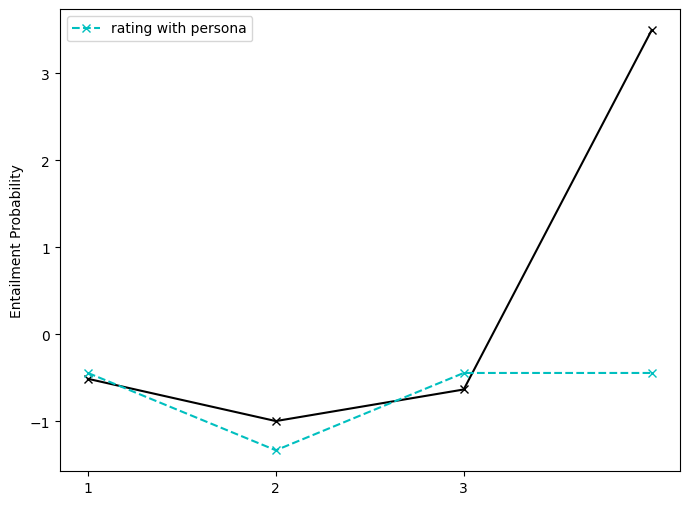

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# def rescale(x):
#     return (2 * (x - 1) / (10 - 1)) - 1

def rescale(x):
    return (x - 1) * (8 / 9) - 4

def llr(pe, pc, eps=0.01):
    return np.log((pe+eps) / (pc+eps))

# ax.plot(range(4), ers[::2, 0] - ers[::2, 2], "ko-", label="last message")
# ax.plot(range(4), ers2[::2, 0] - ers2[::2, 2], "co-", label="context + last message")
# ax.plot(range(4), ers3[::2, 0] - ers3[::2, 2], "kx-", label="persona + last message")
# ax.plot(range(4), ers4[::2, 0] - ers4[::2, 2], "cx-", label="persona + context + last message")

# ax.plot(range(4), llr(ers[::2,0], ers[::2,2]), "ko-")
p0 = (v0+1)/2
ax.plot(range(4), np.log(p0/(1-p0)) + llr(ers2[::2,0], ers[::2,2]), "kx-")

ax.plot(range(4), rescale(rwps[::2]), "cx--", label="rating with persona")
# ax.plot(range(4), rescale(rnps[::2]), "co--", label="rating no persona")

ax.set_xticks(range(3))
ax.set_xticklabels([f"{i+1}" for i in range(3)])
ax.set_ylabel("Entailment Probability")
ax.legend()

In [39]:
rescale(1)

np.float64(0.7310585786300049)

In [48]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(4)

np.float64(0.9820137900379085)

In [61]:
[[f"{p:.2f}" for p in t] for t in ers2[::2,:]]

[['0.00', '1.00', '0.00'],
 ['1.00', '0.00', '0.00'],
 ['1.00', '0.00', '0.00'],
 ['1.00', '0.00', '0.00']]

In [14]:
np.log(0.26/0.06)

np.float64(1.4663370687934272)

In [15]:
np.log(1)

np.float64(0.0)